In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import py0
import maxent
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf
import networkx as nx
from keras.callbacks import ReduceLROnPlateau

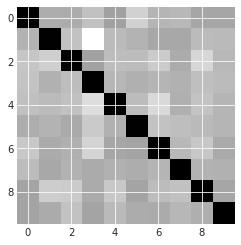

In [2]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
# defining a fully connected mobility matrix
dense_mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
dense_mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(dense_mobility_matrix, dense_mobility_matrix_diag)
dense_mobility_matrix_norm = dense_mobility_matrix / np.sum(dense_mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(dense_mobility_matrix))
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
true_node = 1
infections_compartments = [1,2]
C = len(compartments)

In [3]:
def gen_ref_traj(graph, beta_A = 0.025, beta_I=0.04, alpha =1/3, gamma=1/2, mu=1/7, M=10, C=4, timesteps=100,
                 mobility_matrix=dense_mobility_matrix, population=None, area= None, true_node=None):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, mobility_matrix)
    tmat = py0.TransitionMatrix(compartments, [1,2])
    tmat.add_transition('E', 'A', 1/alpha, 0) # calling this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # calling this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
    model = py0.MetaModel(infect_fxn, timesteps, populations=np.array(population))
    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node true_node
    initial_exposed = 1/population[true_node]
    start[true_node,0] = initial_exposed
    sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(sparsed_mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj


Plotting 10 patches in a 3 x 4 grid


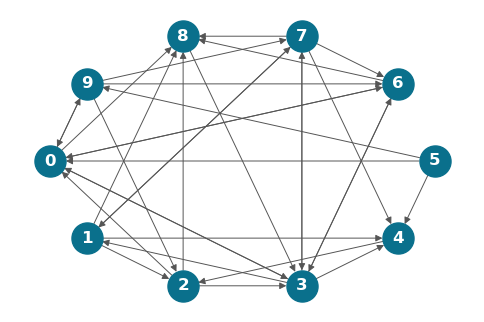

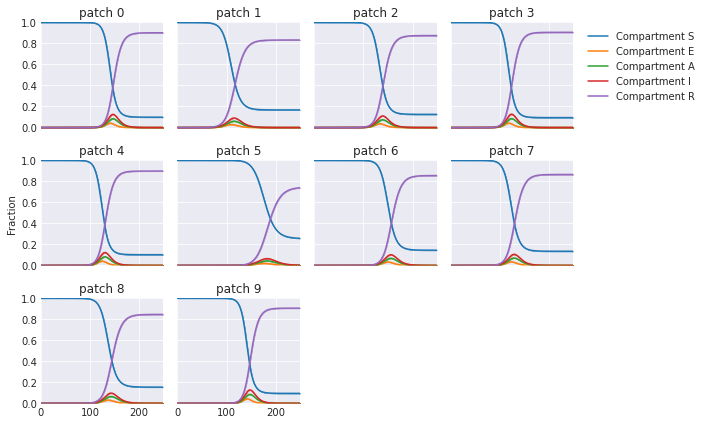

In [4]:
M=10
p = 0.4
graph = py0.gen_random_graph(M,p, seed=0)
py0.draw_graph(graph, dpi =100)
py0.graph_degree(graph)
ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                          area=area, true_node=true_node)
py0.patch_quantile(ref_traj, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])
# plt.savefig('p_0.4_graph.png', dpi=600)

In [5]:
def gen_restraints(ref_traj, prior=None, start=None, end=None):
    if prior:
        prior = maxent.Laplace(1)
    else:
        prior = maxent.EmptyPrior()
    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.05, start_time=start, end_time=end)
    plt.figure()
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observations in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches

In [6]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                py0.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('C0')
                ax[i,j].spines['top'].set_color('C0') 
                ax[i,j].spines['right'].set_color('C0')
                ax[i,j].spines['left'].set_color('C0')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
            if i==2:
                ax[i,j].set_xlabel('Time (days)')
    plt.tight_layout()

def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
    #     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
    #             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                py0.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                py0.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
            if i==2:
                ax[i,j].set_xlabel('Time (days)')
    plt.tight_layout()

In [7]:
def gen_samples(graph, mobility_matrix=dense_mobility_matrix, timesteps =250, area = area, populations = population):
    # sparsify mobility matrix for sparse graphs
    sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, mobility_matrix)
#     sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
    tmat = py0.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 2) # call this alpha
    tmat.add_transition('E', 'I', 2, 2) # call this gamma
    tmat.add_transition('A', 'R',6, 2) # mu
    tmat.add_transition('I', 'R', 6, 2)
    hyper_pram = py0.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 1e-7
    start_logits = np.zeros((M))
    param_model = py0.MetaParameterJoint(start_logits, sparsed_mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 16
    total_batches = N * batches
    outs = []
    infect = py0.contact_infection_func(infections_compartments, area = area)
    model = py0.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    return trajs, prior_prams
trajs, prior_prams = gen_samples(graph, timesteps =250, area = area, populations = population)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


100%|██████████| 16/16 [00:35<00:00,  2.22s/it]


Plotting 10 patches in a 3 x 4 grid


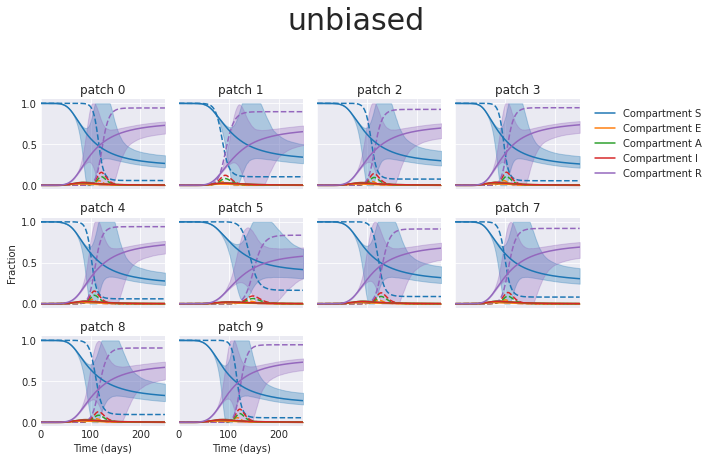

In [86]:
compare_to_ref(ref_traj, trajs, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)
# plt.savefig('p_0.4_sample_traj.png', dpi=600)

Restraints are set in this time range: [50, 140]
94 0.0024702675 0.0026181527479773744
129 0.11957006 0.13082969840137498
115 0.045546804 0.04717333422793961
122 0.0886404 0.09876461030833623
101 0.006946483 0.0074897337729329955
52 5.468274e-06 5.635358270928999e-06
101 0.01032626 0.01086383195416464
129 0.35671487 0.356122085224586
73 0.00014692282 0.0001474050255664892
115 0.07665086 0.07766949310724908
101 0.017251655 0.015132566455589153
108 0.043631326 0.0399147037585648
129 0.11096143 0.11329246906342873
94 0.0061821267 0.006089966933110896
80 0.0007225922 0.0007321160166305622
94 0.008907469 0.009233155416718753
80 0.0010175381 0.0009649190556762643
115 0.17366596 0.17958444383232106
122 0.35048804 0.33640876307098516
59 3.6694557e-05 3.542942073410366e-05
115 0.01662357 0.0157056299841401
66 1.7620172e-05 1.7666129886807503e-05
59 6.369083e-06 6.133566256096789e-06
136 0.10415483 0.11219045401006808
108 0.006630125 0.006201534844622091
94 0.0014937243 0.0015136693144594663
136

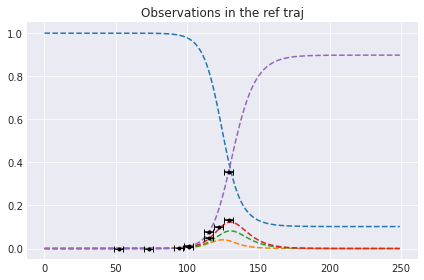

In [8]:
npoints = 5
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)
print(restrained_patches)

<AxesSubplot:ylabel='Count'>

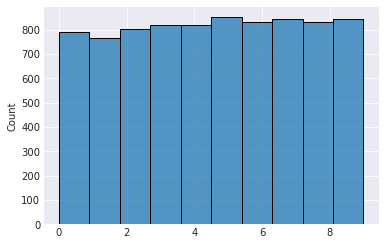

In [13]:
prior_exposed_patch = py0.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior',
            color='C0',bins=M)

In [9]:
def maxent_fit(trajs, restraints):
    me_model = maxent.MaxentModel(restraints)
    from tensorflow import keras
    optimizer=keras.optimizers.Adam(lr=1e-2) 
    me_model.compile(optimizer=optimizer, loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                              patience=10, min_lr=0)
    me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=1000, callbacks=[reduce_lr])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].plot(me_history.history['loss'])
    ax[0].set_yscale('log')
    ax[0].set_title('loss')
#     ax[1].show()
    ax[1].plot(me_history.history['weight-entropy'])
    ax[1].set_title('weight-entropy')
    return me_model

Epoch 1/1000
1/1 [==============================] - 1s 840ms/step - loss: 36.2227 - weight-entropy: 3.7406
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 35.6961 - weight-entropy: 3.6067
Epoch 3/1000
1/1 [==============================] - 0s 4ms/step - loss: 35.2099 - weight-entropy: 3.5169
Epoch 4/1000
1/1 [==============================] - 0s 4ms/step - loss: 34.6463 - weight-entropy: 3.4782
Epoch 5/1000
1/1 [==============================] - 0s 3ms/step - loss: 33.7267 - weight-entropy: 3.5148
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 31.7273 - weight-entropy: 3.6707
Epoch 7/1000
1/1 [==============================] - 0s 3ms/step - loss: 27.3330 - weight-entropy: 3.9714
Epoch 8/1000
1/1 [==============================] - 0s 3ms/step - loss: 19.5527 - weight-entropy: 4.3116
Epoch 9/1000
1/1 [==============================] - 0s 3ms/step - loss: 10.8763 - weight-entropy: 4.3566
Epoch 10/1000
1/1 [==============================] - 

1/1 [==============================] - 0s 3ms/step - loss: 0.7895 - weight-entropy: 4.0649
Epoch 80/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7461 - weight-entropy: 4.0173
Epoch 81/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7178 - weight-entropy: 3.9711
Epoch 82/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.7007 - weight-entropy: 3.9301
Epoch 83/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6908 - weight-entropy: 3.8959
Epoch 84/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6849 - weight-entropy: 3.8686
Epoch 85/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6809 - weight-entropy: 3.8477
Epoch 86/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.6776 - weight-entropy: 3.8322
Epoch 87/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6743 - weight-entropy: 3.8213
Epoch 88/1000
1/1 [==============================] - 0s 3ms/step - lo

1/1 [==============================] - 0s 3ms/step - loss: 0.5084 - weight-entropy: 3.8856
Epoch 157/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5060 - weight-entropy: 3.8886
Epoch 158/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5036 - weight-entropy: 3.8918
Epoch 159/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.5011 - weight-entropy: 3.8950
Epoch 160/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4987 - weight-entropy: 3.8983
Epoch 161/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4963 - weight-entropy: 3.9018
Epoch 162/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4939 - weight-entropy: 3.9053
Epoch 163/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4914 - weight-entropy: 3.9090
Epoch 164/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4890 - weight-entropy: 3.9127
Epoch 165/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.3587 - weight-entropy: 4.1242
Epoch 234/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3574 - weight-entropy: 4.1249
Epoch 235/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3561 - weight-entropy: 4.1257
Epoch 236/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.3548 - weight-entropy: 4.1264
Epoch 237/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3536 - weight-entropy: 4.1272
Epoch 238/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3524 - weight-entropy: 4.1280
Epoch 239/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3511 - weight-entropy: 4.1288
Epoch 240/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3499 - weight-entropy: 4.1296
Epoch 241/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.3487 - weight-entropy: 4.1304
Epoch 242/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 4ms/step - loss: 0.2824 - weight-entropy: 4.1939
Epoch 311/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2817 - weight-entropy: 4.1947
Epoch 312/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2809 - weight-entropy: 4.1955
Epoch 313/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2802 - weight-entropy: 4.1963
Epoch 314/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2794 - weight-entropy: 4.1971
Epoch 315/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2787 - weight-entropy: 4.1978
Epoch 316/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2779 - weight-entropy: 4.1986
Epoch 317/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2772 - weight-entropy: 4.1994
Epoch 318/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2765 - weight-entropy: 4.2002
Epoch 319/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.2341 - weight-entropy: 4.2492
Epoch 388/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2335 - weight-entropy: 4.2499
Epoch 389/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2330 - weight-entropy: 4.2505
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2325 - weight-entropy: 4.2512
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2320 - weight-entropy: 4.2518
Epoch 392/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2315 - weight-entropy: 4.2525
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2310 - weight-entropy: 4.2531
Epoch 394/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2305 - weight-entropy: 4.2538
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.2300 - weight-entropy: 4.2544
Epoch 396/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 4ms/step - loss: 0.1994 - weight-entropy: 4.2950
Epoch 465/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1991 - weight-entropy: 4.2956
Epoch 466/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1987 - weight-entropy: 4.2961
Epoch 467/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1983 - weight-entropy: 4.2966
Epoch 468/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1979 - weight-entropy: 4.2972
Epoch 469/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1975 - weight-entropy: 4.2977
Epoch 470/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1971 - weight-entropy: 4.2982
Epoch 471/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1968 - weight-entropy: 4.2987
Epoch 472/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1964 - weight-entropy: 4.2993
Epoch 473/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1729 - weight-entropy: 4.3311
Epoch 542/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1726 - weight-entropy: 4.3315
Epoch 543/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1723 - weight-entropy: 4.3319
Epoch 544/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1720 - weight-entropy: 4.3323
Epoch 545/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1717 - weight-entropy: 4.3327
Epoch 546/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1714 - weight-entropy: 4.3331
Epoch 547/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1711 - weight-entropy: 4.3335
Epoch 548/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1708 - weight-entropy: 4.3339
Epoch 549/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1705 - weight-entropy: 4.3343
Epoch 550/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1519 - weight-entropy: 4.3569
Epoch 619/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1516 - weight-entropy: 4.3572
Epoch 620/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1514 - weight-entropy: 4.3574
Epoch 621/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1511 - weight-entropy: 4.3577
Epoch 622/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1509 - weight-entropy: 4.3580
Epoch 623/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1506 - weight-entropy: 4.3582
Epoch 624/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1504 - weight-entropy: 4.3585
Epoch 625/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1501 - weight-entropy: 4.3587
Epoch 626/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1499 - weight-entropy: 4.3590
Epoch 627/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1346 - weight-entropy: 4.3733
Epoch 696/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1344 - weight-entropy: 4.3734
Epoch 697/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1342 - weight-entropy: 4.3736
Epoch 698/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1340 - weight-entropy: 4.3737
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1338 - weight-entropy: 4.3739
Epoch 700/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1336 - weight-entropy: 4.3740
Epoch 701/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1334 - weight-entropy: 4.3742
Epoch 702/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1332 - weight-entropy: 4.3743
Epoch 703/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1330 - weight-entropy: 4.3745
Epoch 704/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1203 - weight-entropy: 4.3821
Epoch 773/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1201 - weight-entropy: 4.3822
Epoch 774/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1199 - weight-entropy: 4.3822
Epoch 775/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1197 - weight-entropy: 4.3823
Epoch 776/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1196 - weight-entropy: 4.3824
Epoch 777/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1194 - weight-entropy: 4.3825
Epoch 778/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1192 - weight-entropy: 4.3825
Epoch 779/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1191 - weight-entropy: 4.3826
Epoch 780/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1189 - weight-entropy: 4.3827
Epoch 781/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.1080 - weight-entropy: 4.3854
Epoch 850/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1078 - weight-entropy: 4.3855
Epoch 851/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1077 - weight-entropy: 4.3855
Epoch 852/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1076 - weight-entropy: 4.3855
Epoch 853/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1074 - weight-entropy: 4.3855
Epoch 854/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1073 - weight-entropy: 4.3855
Epoch 855/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1071 - weight-entropy: 4.3855
Epoch 856/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1070 - weight-entropy: 4.3855
Epoch 857/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1068 - weight-entropy: 4.3855
Epoch 858/1000
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 3ms/step - loss: 0.0974 - weight-entropy: 4.3850
Epoch 927/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0972 - weight-entropy: 4.3850
Epoch 928/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0971 - weight-entropy: 4.3850
Epoch 929/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0970 - weight-entropy: 4.3850
Epoch 930/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0969 - weight-entropy: 4.3849
Epoch 931/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0967 - weight-entropy: 4.3849
Epoch 932/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0966 - weight-entropy: 4.3849
Epoch 933/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0965 - weight-entropy: 4.3849
Epoch 934/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0963 - weight-entropy: 4.3848
Epoch 935/1000
1/1 [==============================] - 0s 3ms/

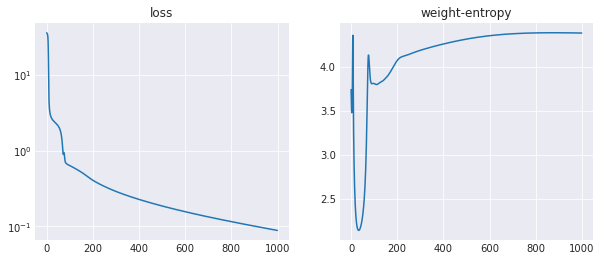

In [10]:
me_model = maxent_fit(trajs, restraints)

Plotting 10 patches in a 3 x 4 grid


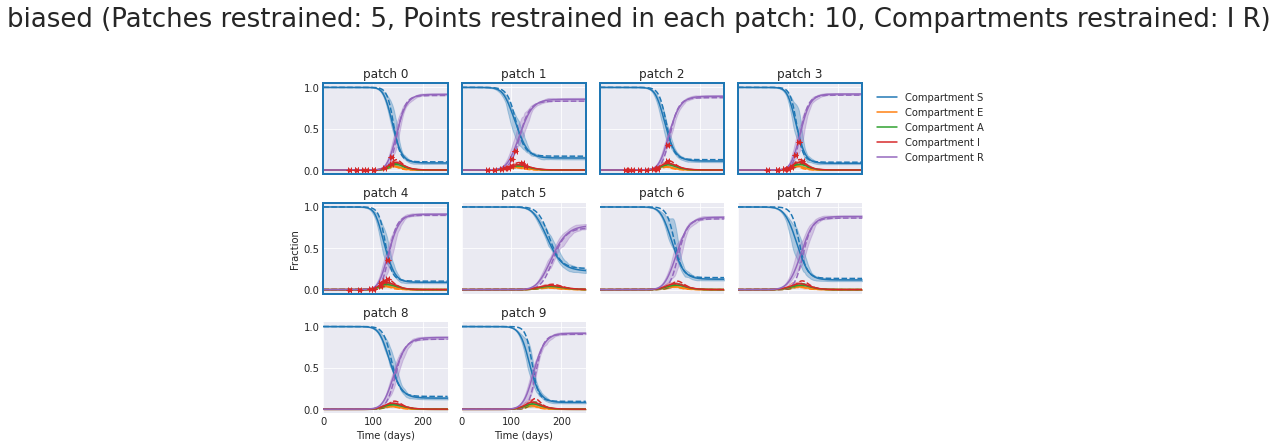

In [11]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)
plt.tight_layout()
# plt.savefig('p_0.4_posterior.png', dpi=600)

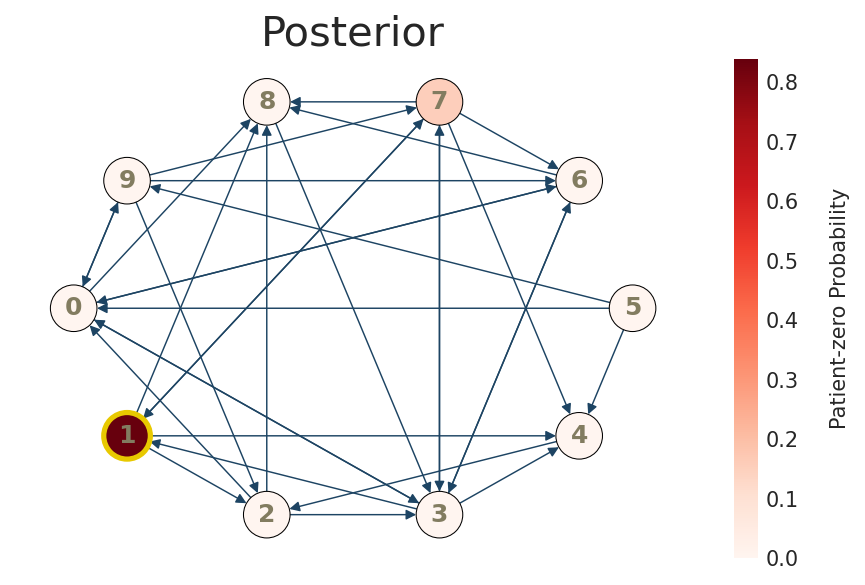

In [14]:
me_w = me_model.traj_weights
exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M)
weighted_exposed_prob = py0.weighted_exposed_prob_finder(
                            prior_exposed_patch, M, weights=me_w)
# py0.draw_graph(graph, weights=exposed_prob, title='Prior', heatmap=True, true_origin=true_node)
# fig, ax = plt.subplots()
py0.draw_graph(graph, weights=weighted_exposed_prob, title='Posterior', heatmap=True, true_origin=true_node)
plt.tight_layout()
# plt.savefig('p_0.4_p0_posterior.png', dpi=600)

In [15]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
#         R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
#     R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta^-1
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get gamma^-1
    E_I = 1/T_dist[:, compartments.index('E'), compartments.index('I')].numpy()
    # get mu^-1
    A_R = 1/T_dist[:, compartments.index('A'), compartments.index('R')].numpy()
    # get mu^-1
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [E_A, E_I,A_R, I_R, start_exposed_dist, beta_dist]

prior_param_dist = get_dist(prior_prams)
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist

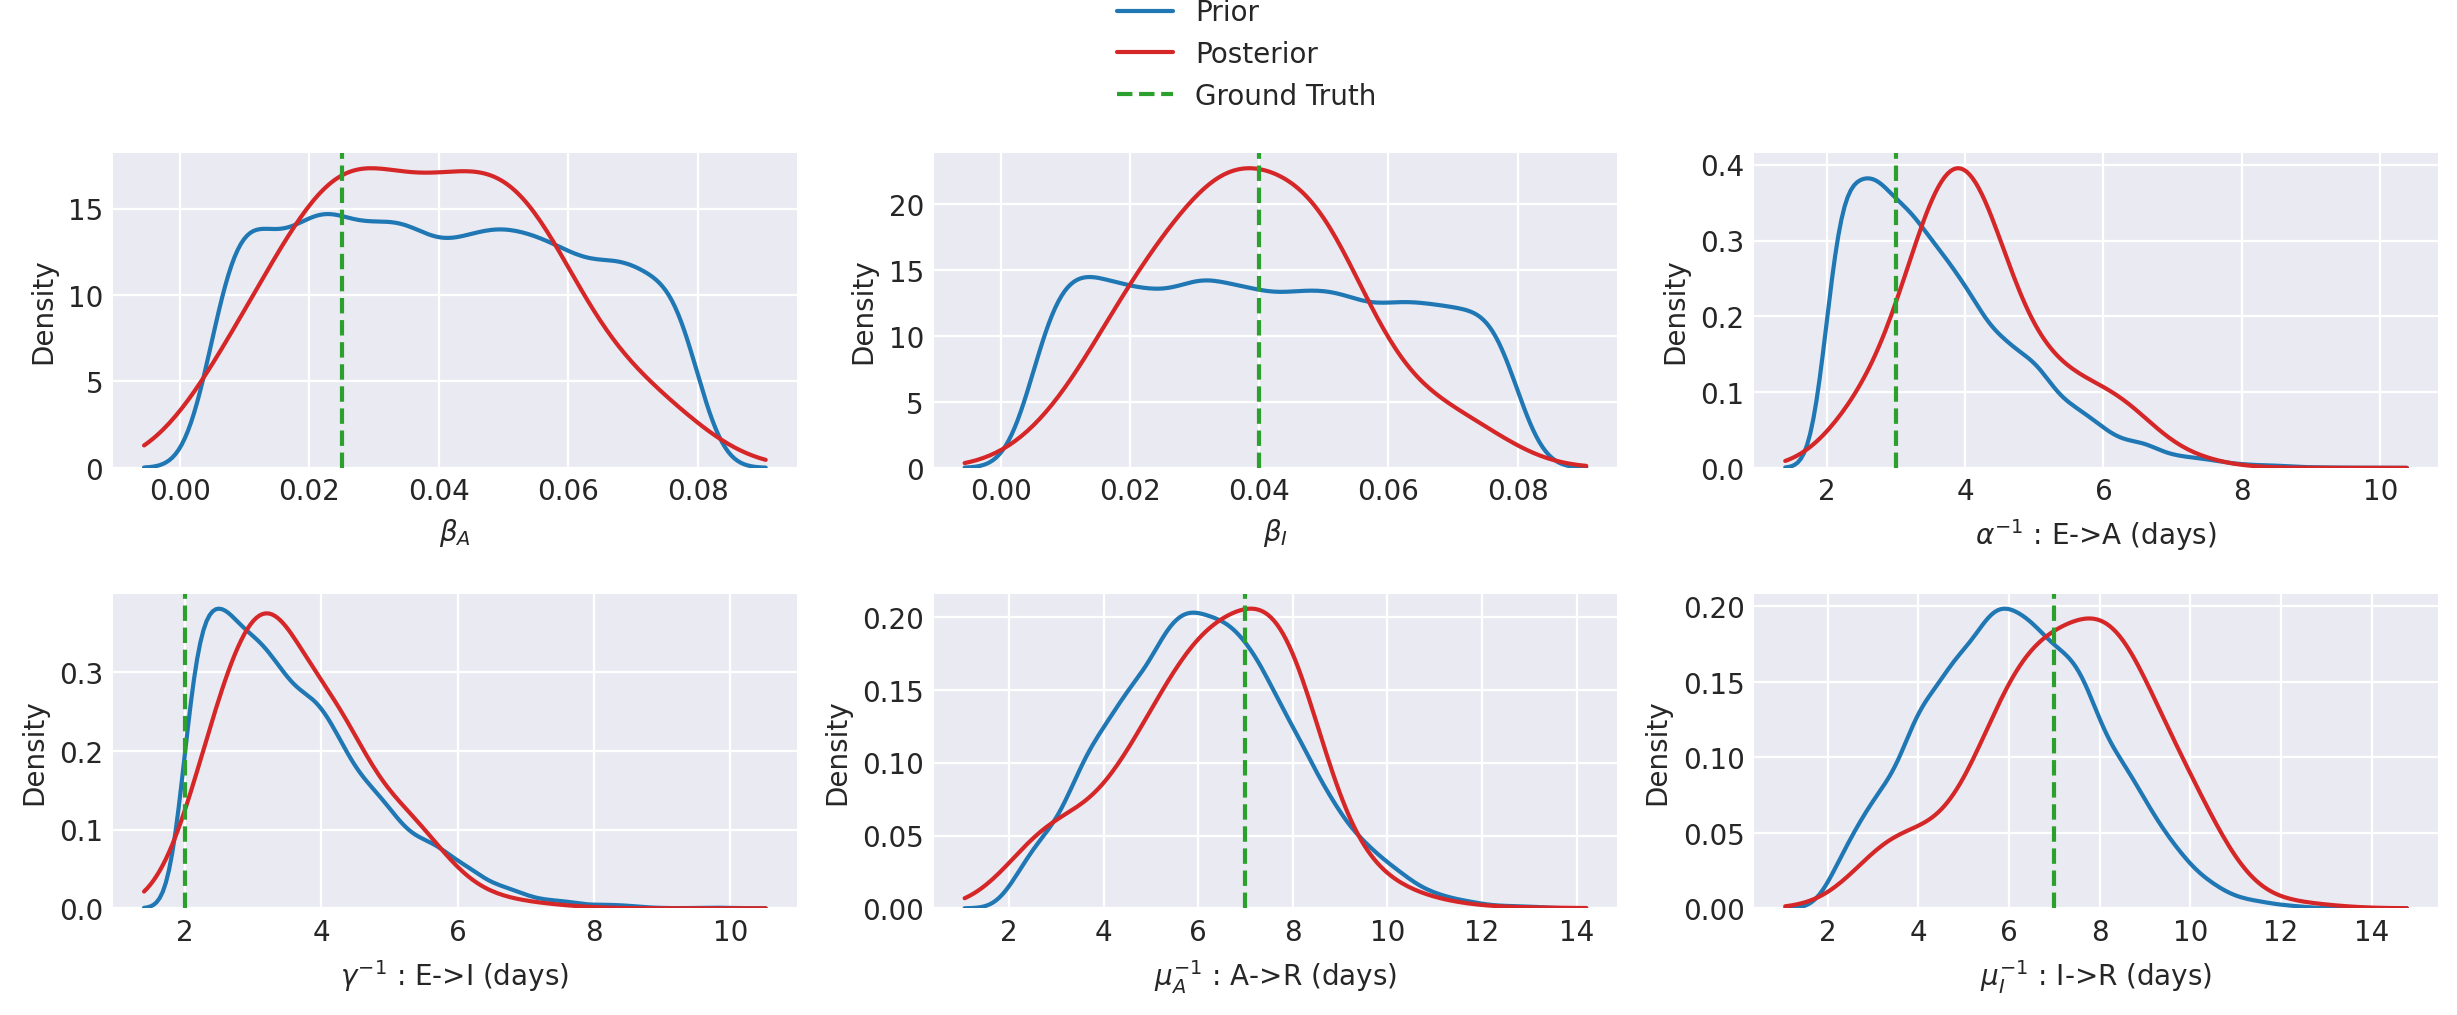

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


beta_A = 0.025
beta_I=0.04
alpha =1/3
gamma=1/2
mu=1/7
axs[0,0].axvline(x=beta_A, color='C2', linestyle='--', label= 'Ground Truth')
axs[0,1].axvline(x=beta_I, color='C2', linestyle='--')
axs[0,2].axvline(x=(1/alpha), color='C2', linestyle='--')
axs[1,0].axvline(x=(1/gamma), color='C2', linestyle='--')
axs[1,1].axvline(x=1/mu, color='C2', linestyle='--')
axs[1,2].axvline(x=1/mu, color='C2', linestyle='--')
handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc=(0.45,0.88))
plt.subplots_adjust(hspace=0.4)
plt.savefig('parameter_dist.svg', dpi=300)

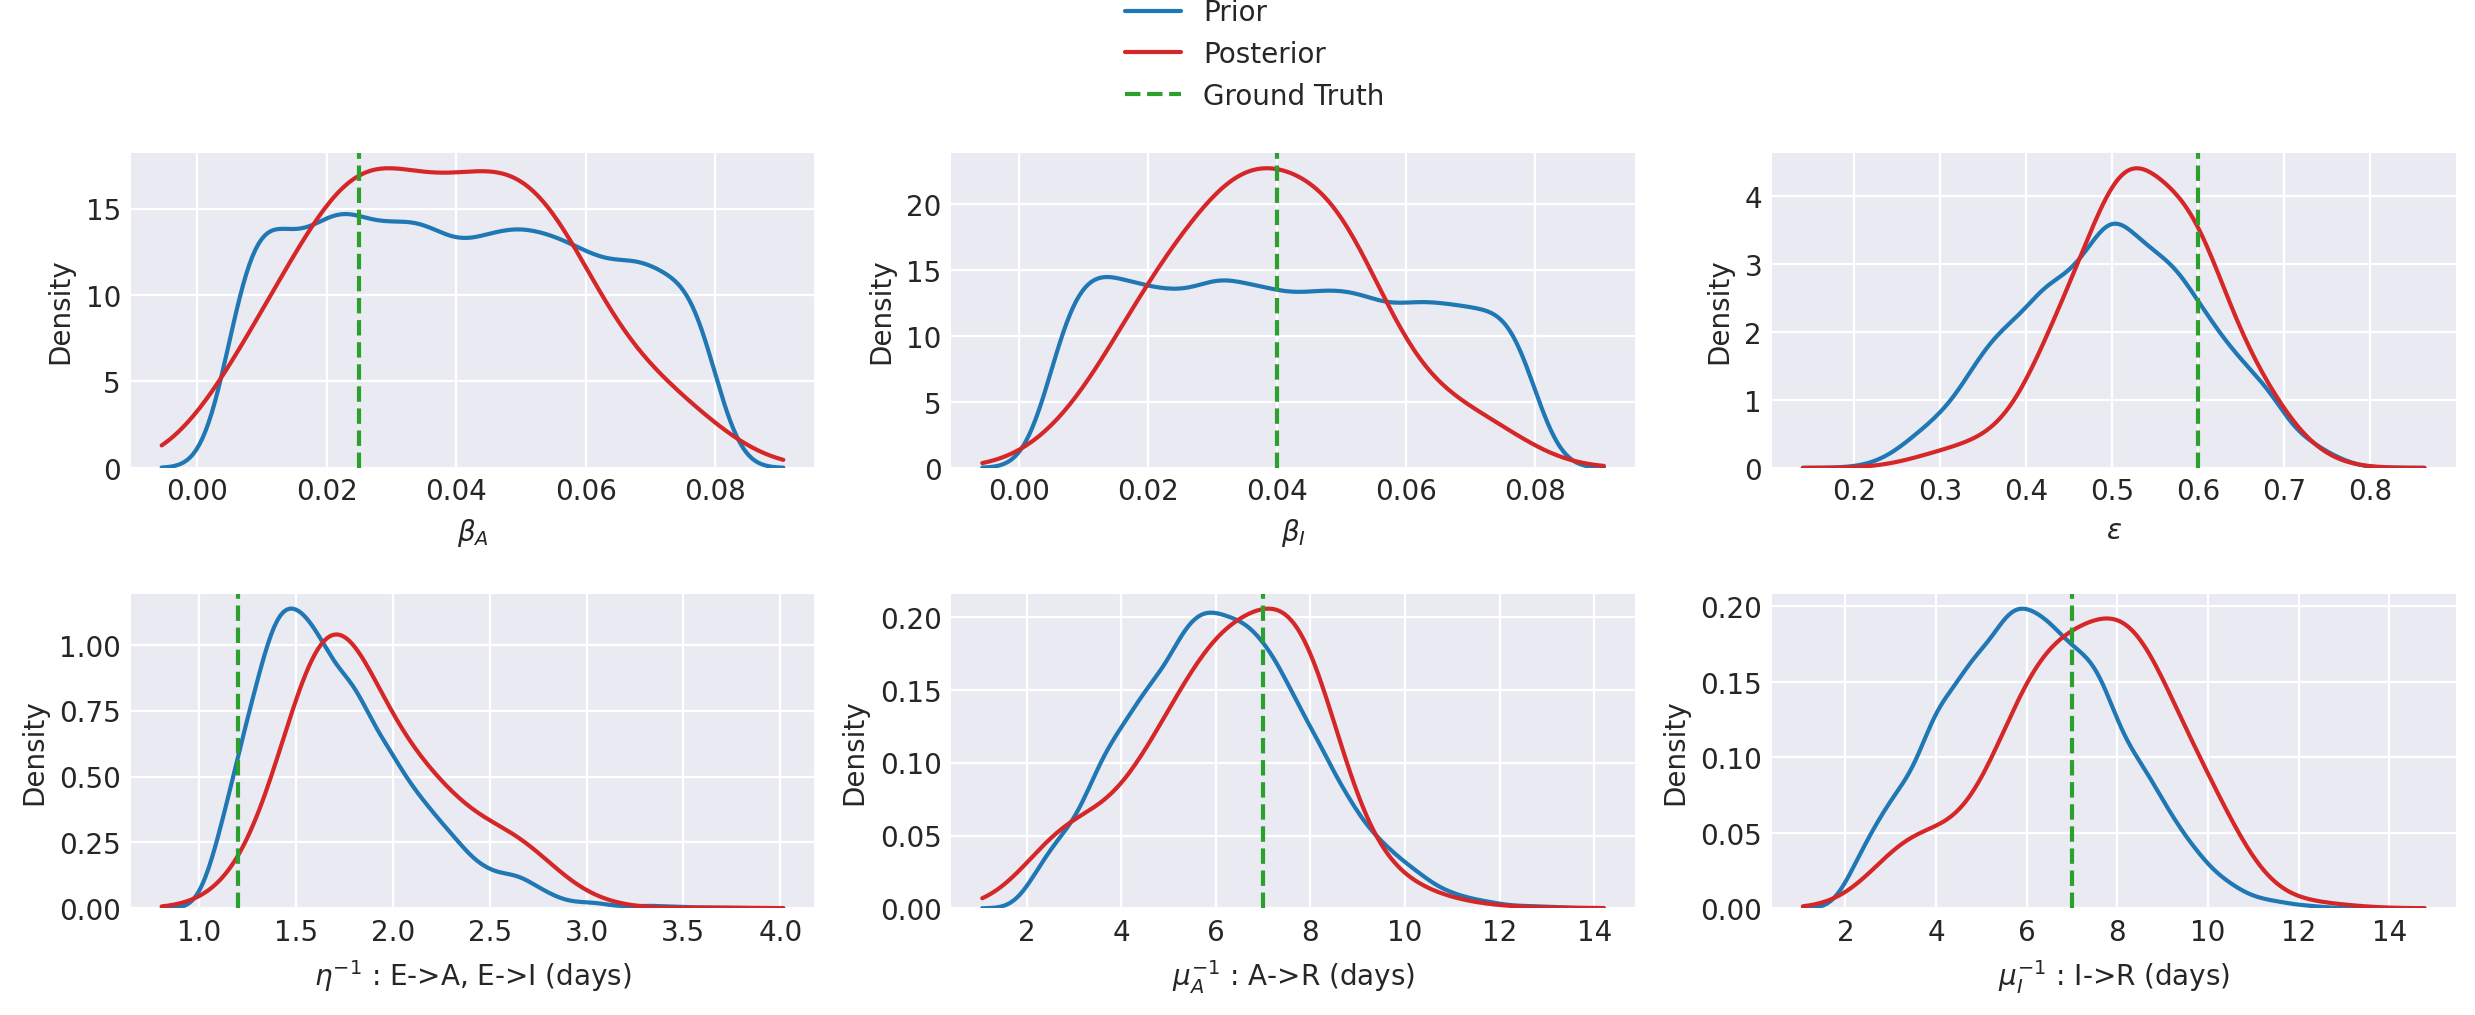

In [22]:
# eta = alpha + gamma
# epsilon = gamma/(alpha+gamma)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=1/np.squeeze(E_I)/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=1/np.squeeze(E_I)/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\epsilon$')

sns.kdeplot(x=1/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=1/(1/np.squeeze(E_I)+ 1/np.squeeze(E_A)) , weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\eta ^{-1}$ : E->A, E->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


beta_A = 0.025
beta_I=0.04
alpha =1/3
gamma=1/2
mu=1/7
axs[0,0].axvline(x=beta_A, color='C2', linestyle='--', label= 'Ground Truth')
axs[0,1].axvline(x=beta_I, color='C2', linestyle='--')
axs[0,2].axvline(x=gamma/(alpha+gamma), color='C2', linestyle='--')
axs[1,0].axvline(x=1/(alpha+gamma), color='C2', linestyle='--')
axs[1,1].axvline(x=1/mu, color='C2', linestyle='--')
axs[1,2].axvline(x=1/mu, color='C2', linestyle='--')
handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc=(0.45,0.88))
plt.subplots_adjust(hspace=0.4)
plt.savefig('parameter_dist_with_epsilon_eta.svg', dpi=300)

In [24]:
traj_loss = py0.traj_loss(ref_traj, trajs, me_w)
p0_loss = py0.p0_loss(trajs,me_w, true_node)
# posterior_exposed_prob = py0.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])

P0 cross-entropy : 0.174, Traj KL : 0.007
Top 5 posterior probabilities for P0: 
 [(0.8400301557004766, 'patch 1'), (0.15701423244152352, 'patch 7'), (0.0021451724573323216, 'patch 4'), (0.0004717617622920601, 'patch 3'), (0.0002359786845847179, 'patch 8')]


In [173]:
run_doe = False
dat=[]
if run_doe:
    for i,p in enumerate(connecting_probability):
        M=10
        true_node = np.random.randint(M)
        graph = py0.gen_random_graph(M,p)
        ref_traj = gen_ref_traj(graph, timesteps=250, population=population,
                                  area=area, true_node=true_node)
        trajs = gen_samples(graph, timesteps =250, area = area, populations = population)
        npoints = 5
        number_of_restrained_patches = 5
        restrained_compartments = [3,4] #(infected patch and recovered)
        number_of_restrained_compartments = len(restrained_compartments) 
        restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
        restrained_compartments_names = " ".join(restrained_compartments_names)
    #     plt.figure()
        restraints, plot_fxns_list, restrained_patches = gen_restraints(ref_traj, prior=True, start=50, end=140)
        prior_exposed_patch = py0.exposed_finder(trajs)
        me_model = maxent_fit(trajs, restraints)
        weights_dict = {'unbiased':None, 'biased':me_model.traj_weights}
        me_w = me_model.traj_weights
        exposed_prob = py0.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M)
        weighted_exposed_prob = py0.weighted_exposed_prob_finder(
                                    prior_exposed_patch, M, weights=me_w)
        traj_loss = py0.traj_loss(ref_traj, trajs, me_w).numpy()
        p0_loss = py0.p0_loss(trajs,me_w, true_node)
        compare_patches(ref_traj, trajs, weights_dict,'biased', restrained_patches, plot_fxns_list,
                    patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)
        fig, ax = plt.subplots()
        py0.draw_graph(graph, weights=weighted_exposed_prob, title=f'Posterior - P = {p:.3f}', heatmap=True, true_origin=true_node)
        print(f'P0 cross-entropy : {p0_loss:.3f}, Traj KL : {traj_loss:.3f}')
        print(f'Iteration: {i}, p: {p}, True_node: {true_node}'
              '\nTop 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob, patches), reverse=True)[:5])
        p0_pred = sorted(zip(weighted_exposed_prob, patches), reverse=True)[:1][0]
        certainty = p0_pred[0]
        predcited_node = int(p0_pred[1].split()[1])
        if predcited_node == true_node:
            prediction = True
        else:
            prediction = False
        dat.append([traj_loss, p0_loss, certainty, prediction, true_node, predcited_node])
    with open('data.npz', 'wb') as f:
        np.save(f, dat)
else:
#     results = np.load('../examples/data.npz')
    dat = np.load('../examples/shifts_p_data/zipped/p_shifts_lr_0.1_top1.npz')
#     for f in results.files:
#         dat.append(results[f].astype(float))
# dat = np.array(dat)

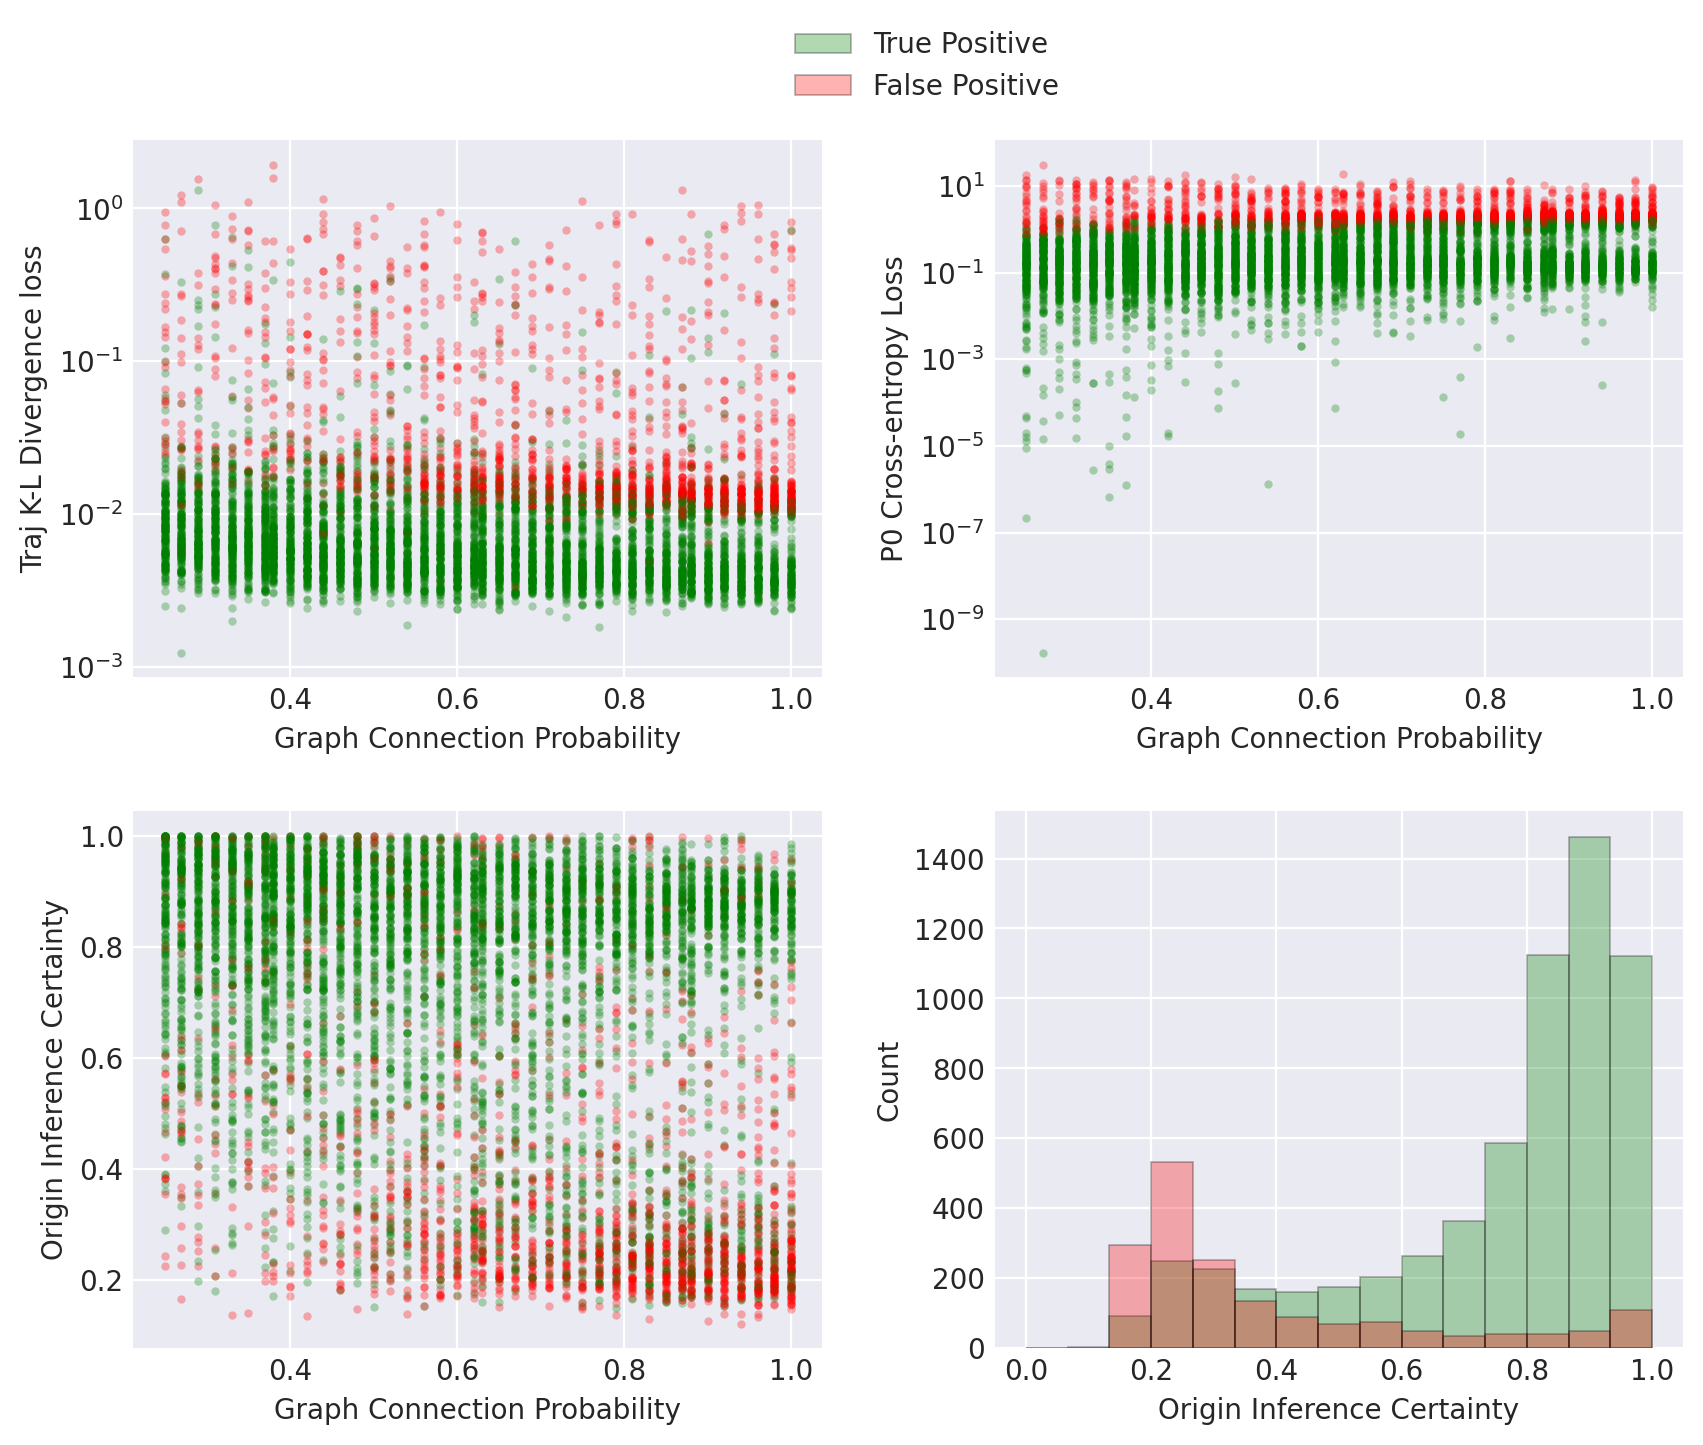

In [175]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.3
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('g')
    else:
        marker_colors.append('r')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=200)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('P0 Cross-entropy Loss')
ax[0,1].set_yscale('log')
ax[1,0].set_xlabel('Graph Connection Probability')
ax[1,0].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probabilities[i], p0_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[1,0].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
    else:
        fps.append(certainties[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,1].hist(tps, bins, alpha=alpha, label='True Positive', color='g', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,1].hist(fps, bins, alpha=alpha, label='False Positive', color='r', rwidth=1, edgecolor='k', linewidth=0.6)
ax[1,1].set_xlabel('Origin Inference Certainty')
ax[1,1].set_ylabel('Count')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.38, 1.25))
bins_t = bins_t[1:]

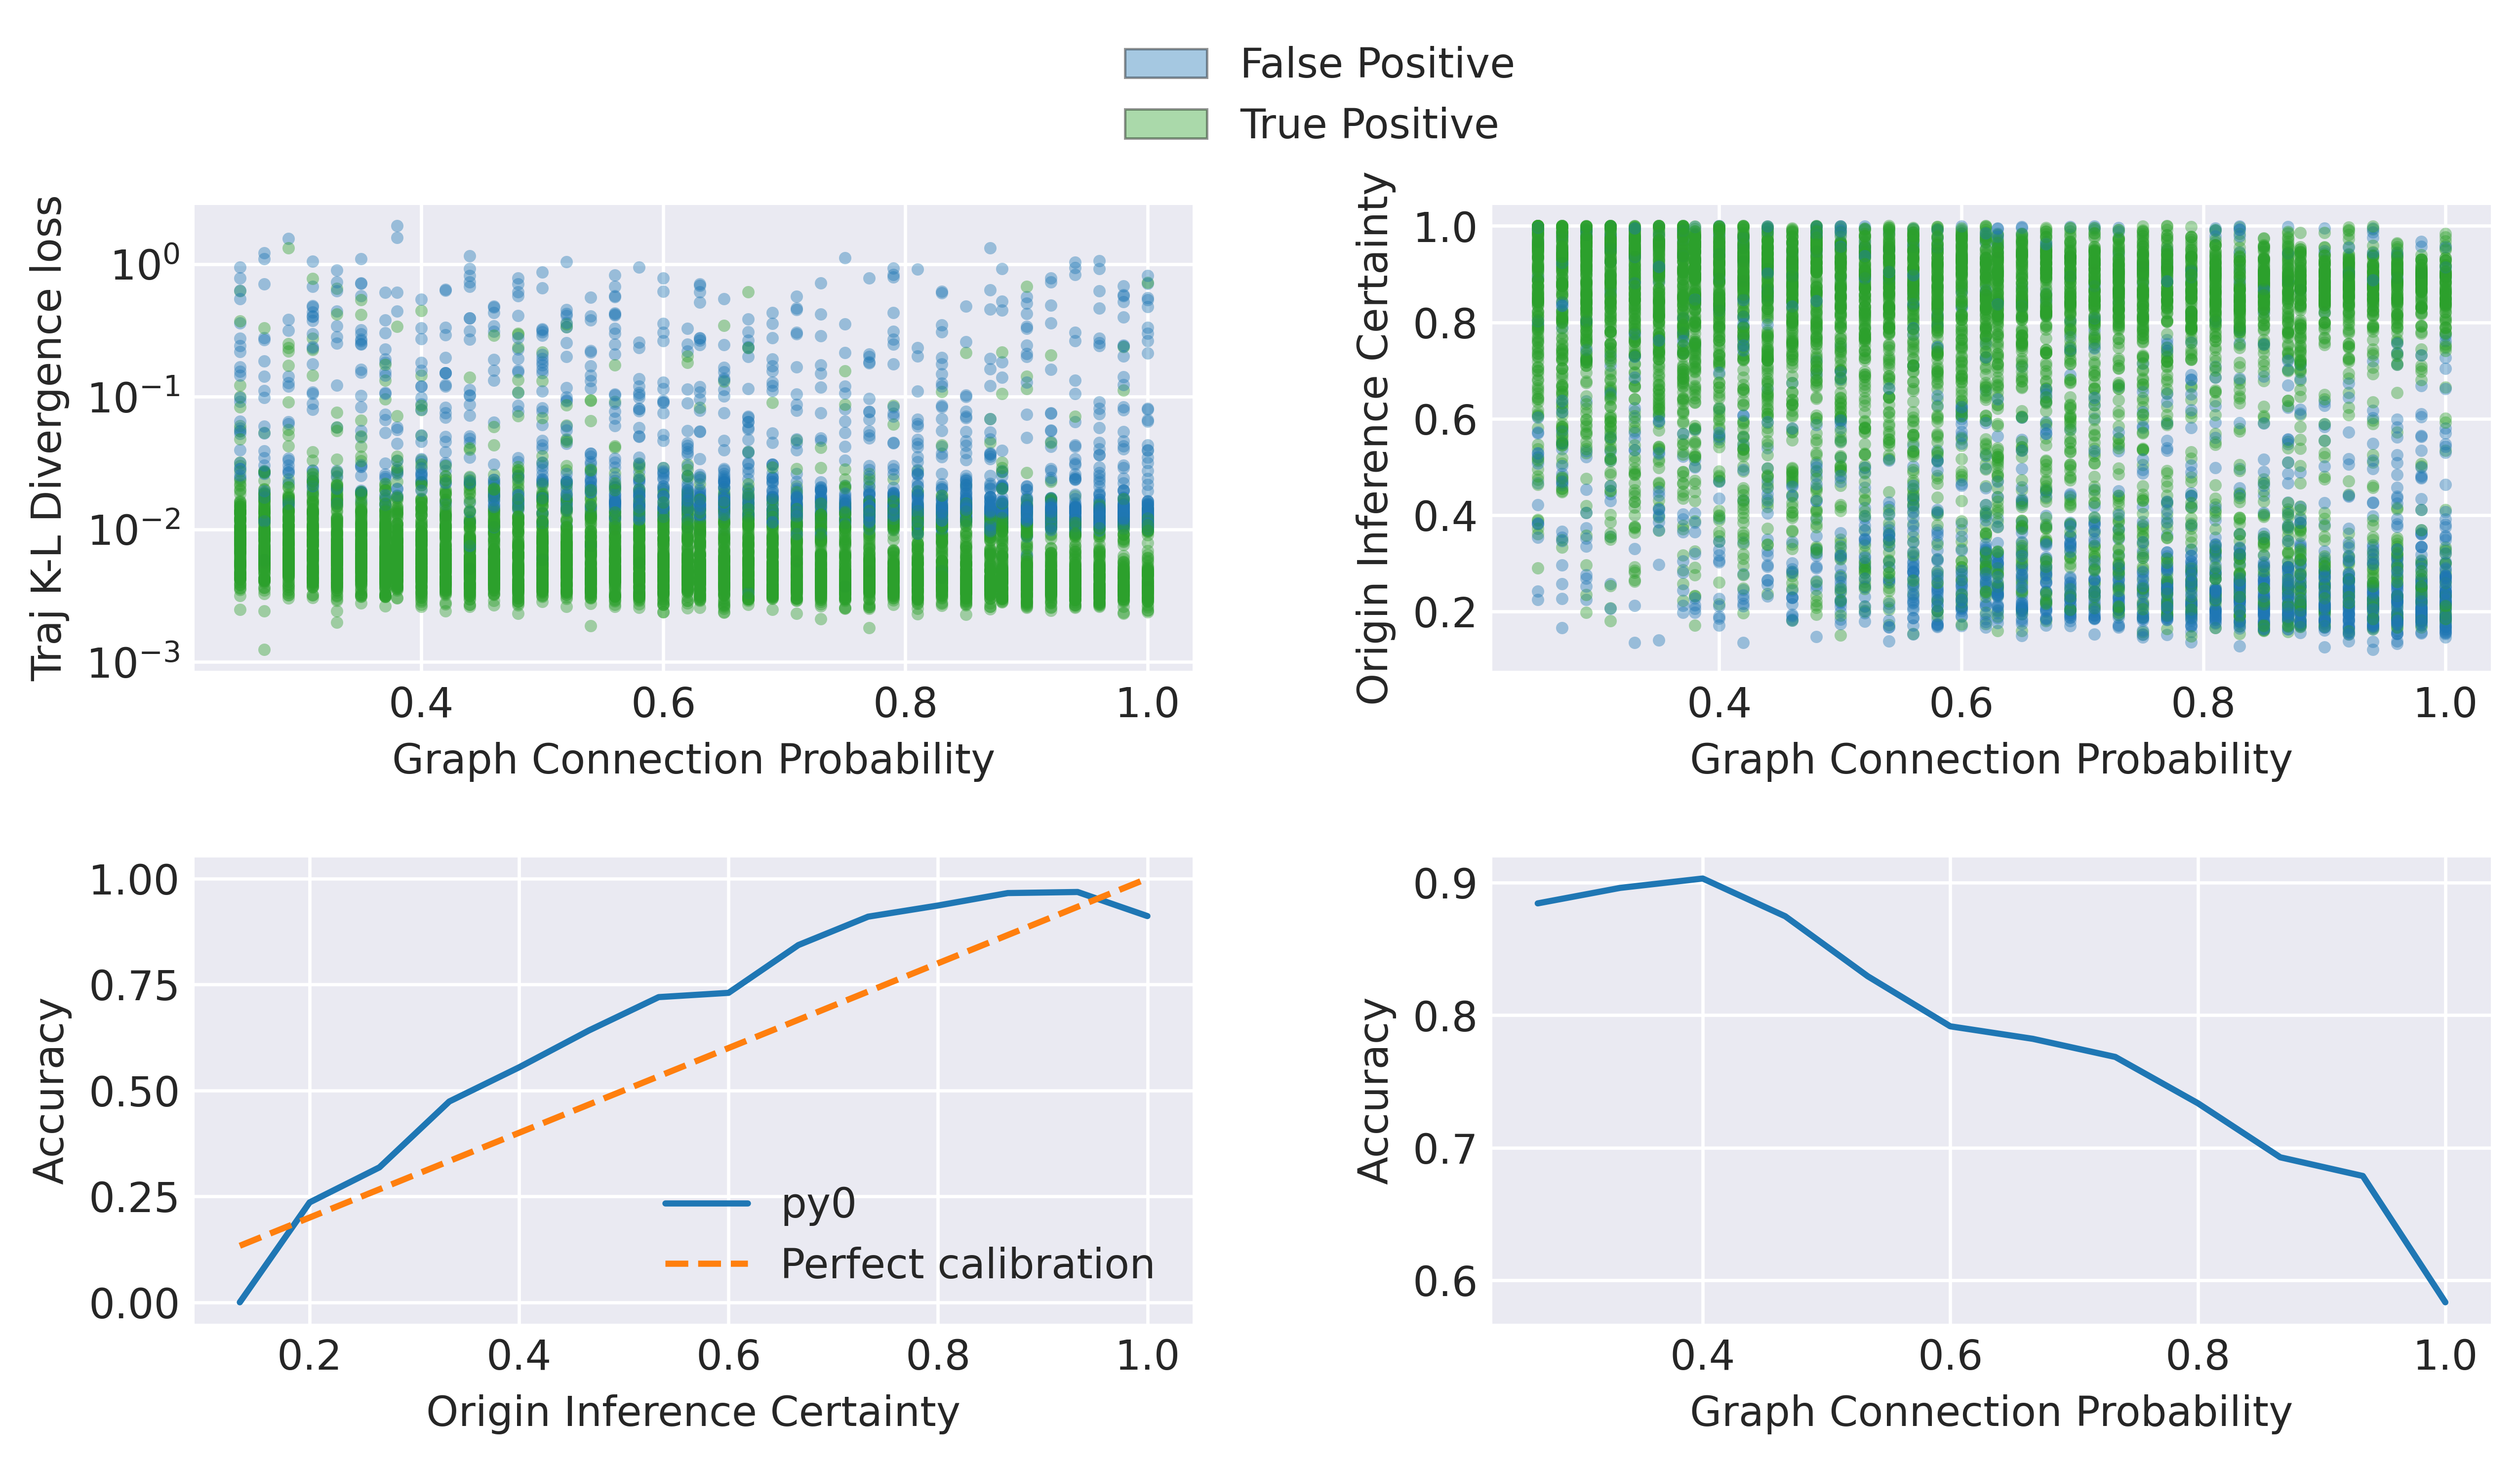

In [181]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.4
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')
# plt.tight_layout()
plt.savefig('adjust_p_grah.png', dpi=600)

In [177]:
min_q = 0.25 
max_q = 0.75
p_values = np.round(np.linspace(0.25, 1, 40), 2)
box_traj_loss_T = []
box_traj_loss_F = []
box_certainty_T = []
box_certainty_F = []
for j, p in enumerate(p_values):
    quant_traj_loss_T = []
    quant_traj_loss_F = []
    quant_certainty_T = []
    quant_certainty_F = []
    for i, d in enumerate(dat):
        if d[0] == p:
            if d[4]:
                quant_traj_loss_T.append(traj_losses[i])
                quant_certainty_T.append(certainties[i])
            else:
                quant_traj_loss_F.append(traj_losses[i])
                quant_certainty_F.append(certainties[i])
    box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
    box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
    box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
    box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
box_traj_loss_T = np.array(box_traj_loss_T)
box_traj_loss_F = np.array(box_traj_loss_F)
box_certainty_T = np.array(box_certainty_T)
box_certainty_F = np.array(box_certainty_F)

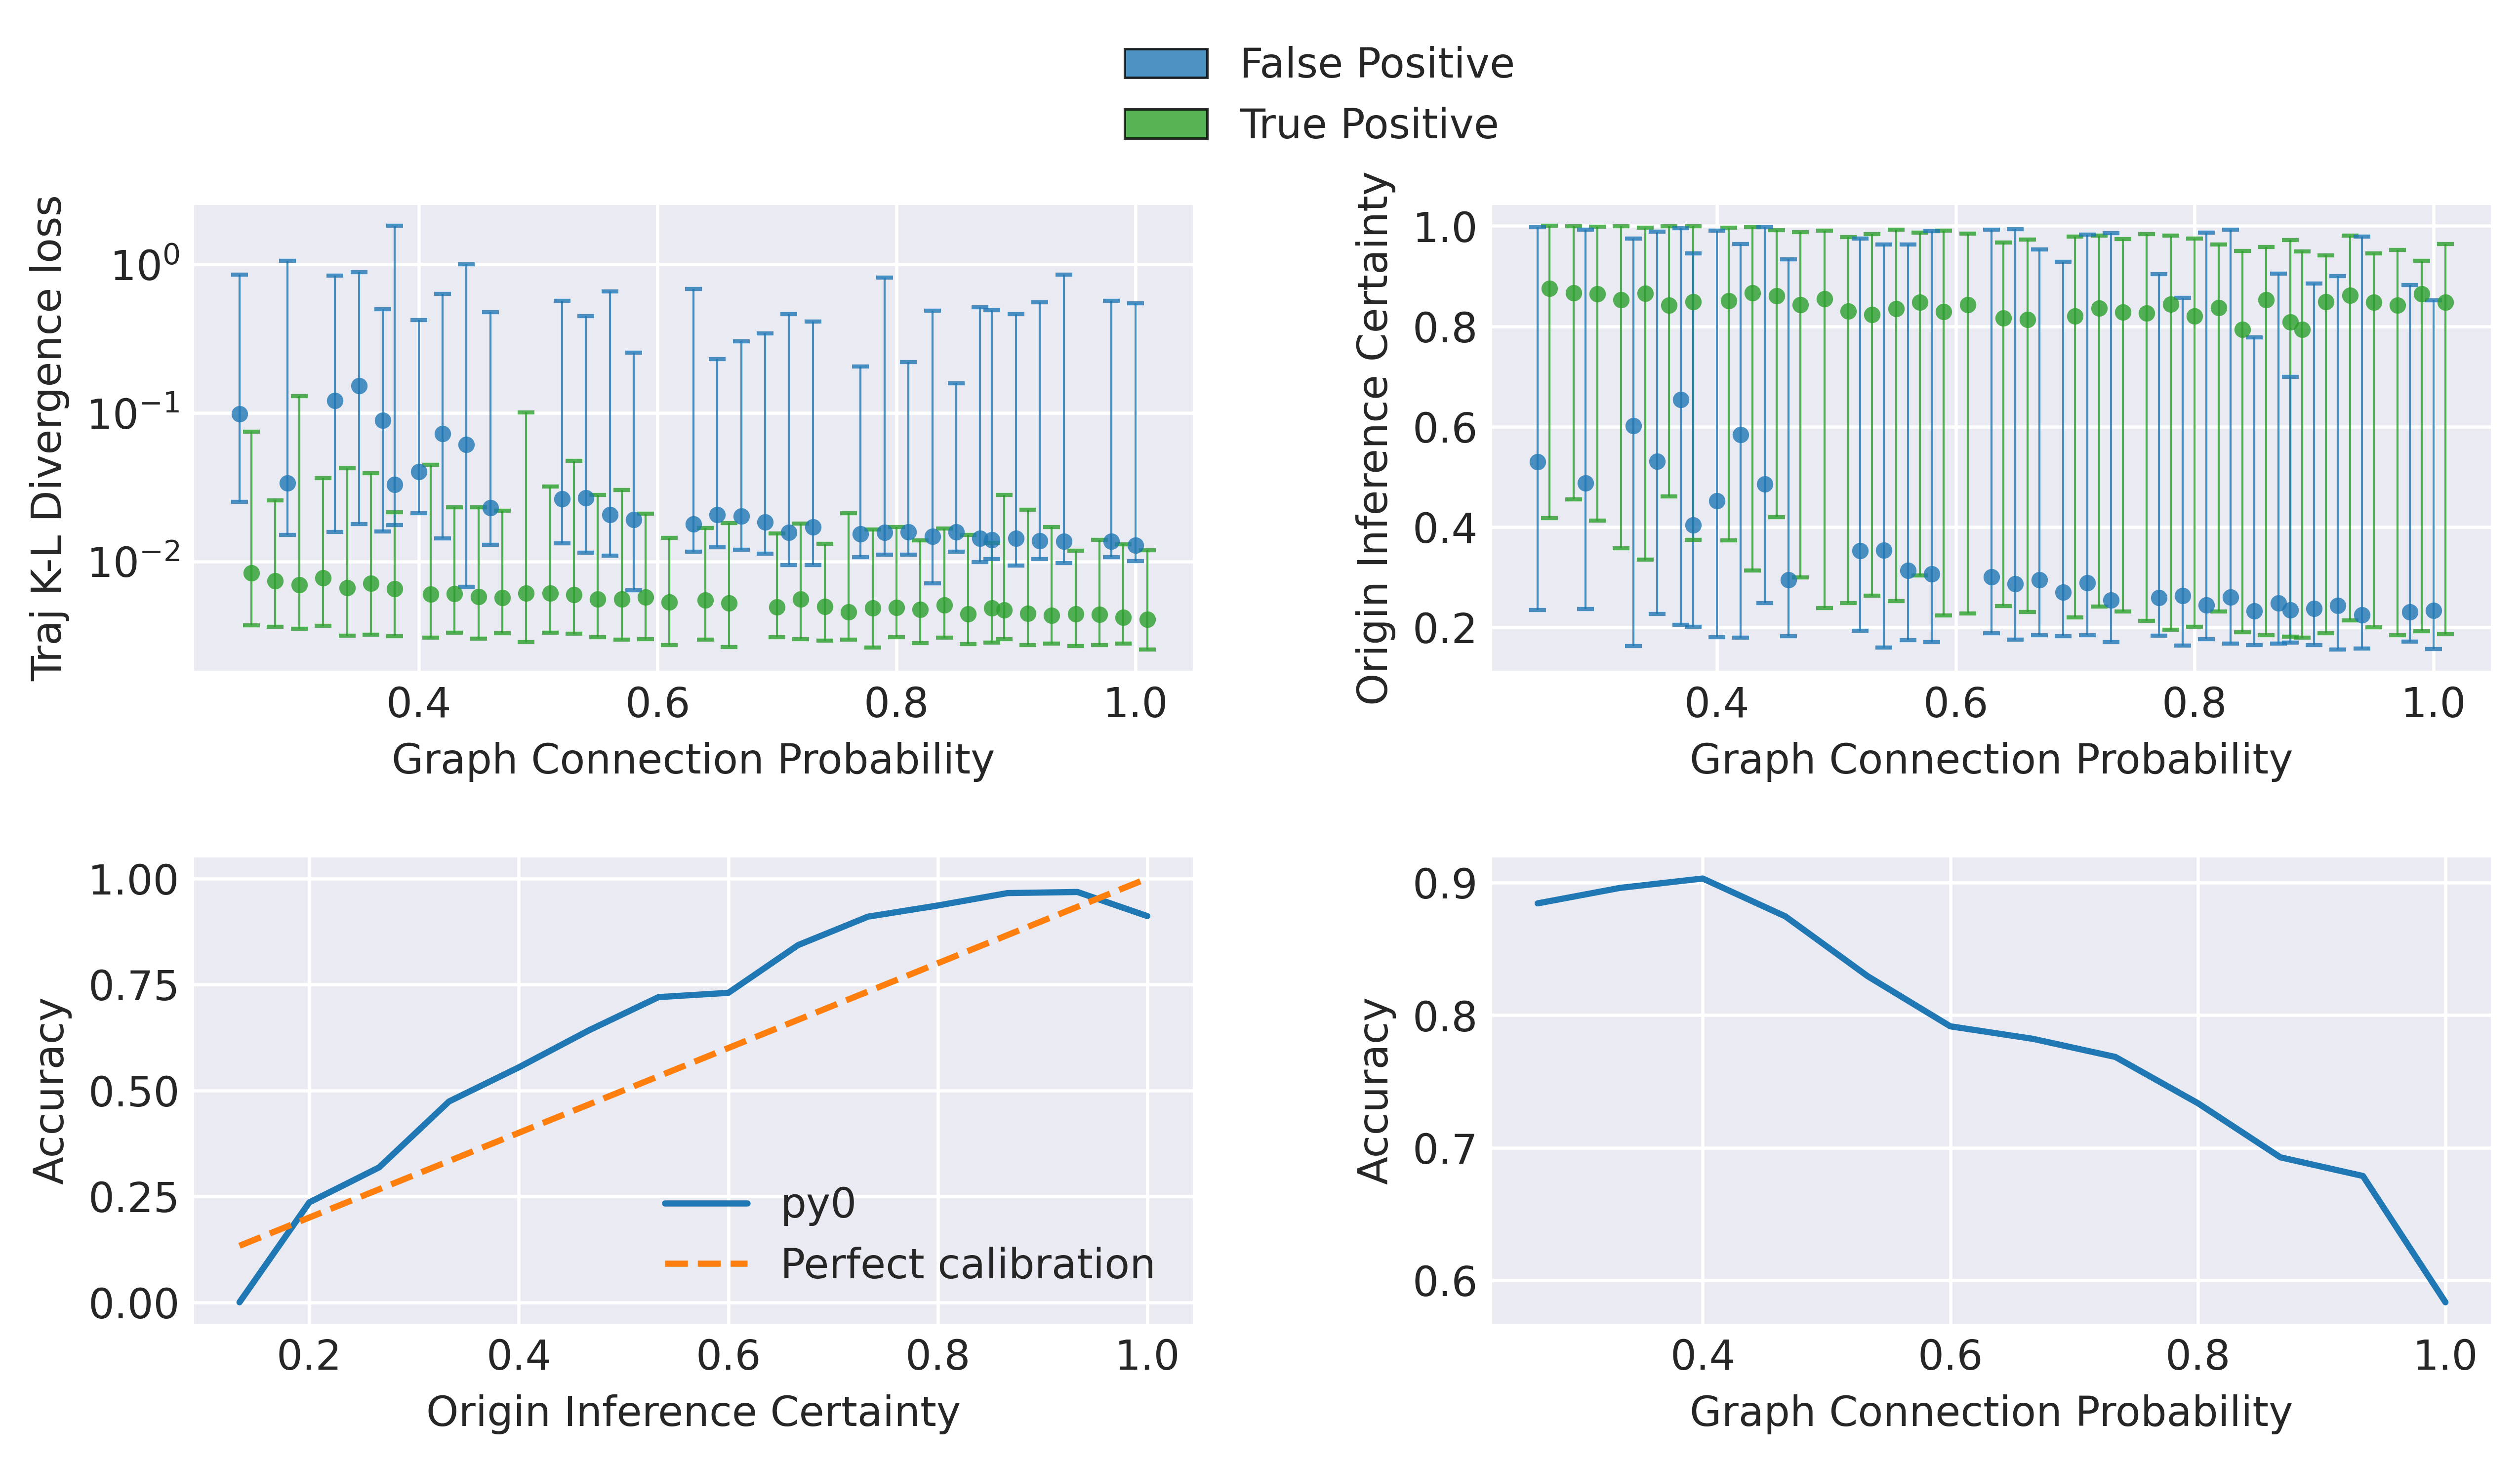

In [180]:
connecting_probabilities, traj_losses, p0_losses  = dat[:, 0], dat[:, 1], dat[:, 2]
certainties, predictions, true_nodes, predicted_nodes, model_fit_losses  = dat[:, 3], dat[:, 4].astype(bool), dat[:, 5], dat[:, 6], dat[:, 7]
marker_colors = []
alpha = 0.8
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probabilities)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []

min_q = 0.025 
max_q = 0.975
p_values = np.round(np.linspace(0.25, 1, 40), 2)
box_traj_loss_T = []
box_traj_loss_F = []
box_certainty_T = []
box_certainty_F = []
for j, p in enumerate(p_values):
    quant_traj_loss_T = []
    quant_traj_loss_F = []
    quant_certainty_T = []
    quant_certainty_F = []
    for i, d in enumerate(dat):
        if d[0] == p:
            if d[4]:
                quant_traj_loss_T.append(traj_losses[i])
                quant_certainty_T.append(certainties[i])
            else:
                quant_traj_loss_F.append(traj_losses[i])
                quant_certainty_F.append(certainties[i])
    box_traj_loss_T.append(np.quantile(np.array(quant_traj_loss_T),[min_q,0.5,max_q]))
    box_traj_loss_F.append(np.quantile(np.array(quant_traj_loss_F),[min_q,0.5,max_q]))
    box_certainty_T.append(np.quantile(np.array(quant_certainty_T),[min_q,0.5,max_q]))
    box_certainty_F.append(np.quantile(np.array(quant_certainty_F),[min_q,0.5,max_q]))
box_traj_loss_T = np.array(box_traj_loss_T)
box_traj_loss_F = np.array(box_traj_loss_F)
box_certainty_T = np.array(box_certainty_T)
box_certainty_F = np.array(box_certainty_F)

ax[0,0].errorbar(p_values+0.01, box_traj_loss_T[:,1], yerr=(box_traj_loss_T[:,1] - box_traj_loss_T[:,0], box_traj_loss_T[:,2] - box_traj_loss_T[:,1]),
                 fmt='o', color='C2', alpha=alpha, elinewidth=0.5, capsize=2, markersize=4,markeredgecolor='None')
ax[0,0].errorbar(p_values, box_traj_loss_F[:,1], yerr=(box_traj_loss_F[:,1] - box_traj_loss_F[:,0], box_traj_loss_F[:,2] - box_traj_loss_F[:,1]),
                 fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
ax[0,1].errorbar(p_values+0.01, box_certainty_T[:,1], yerr=(box_certainty_T[:,1]-box_certainty_T[:,0], box_certainty_T[:,2]-box_certainty_T[:,1]), fmt='o', color='C2', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')
ax[0,1].errorbar(p_values, box_certainty_F[:,1], yerr=(box_certainty_F[:,1]-box_certainty_F[:,0], box_certainty_F[:,2]-box_certainty_F[:,1]), fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4, markeredgecolor='None')

for i, mc in enumerate(marker_colors):
#     ax[0,0].plot(connecting_probabilities[i], traj_losses[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
#     ax[0,1].plot(connecting_probabilities[i], certainties[i], marker='.', markerfacecolor=mc,
#                markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probabilities[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probabilities[i])
bins = np.linspace(0,1,16)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probabilities)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')
# plt.tight_layout()
plt.savefig('adjust_p_grah_error_bars.png', dpi=600)

In [12]:
p_values+0.01

array([0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.39, 0.41, 0.43, 0.45,
       0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01])

NameError: name 'box_T' is not defined

<Figure size 720x720 with 0 Axes>

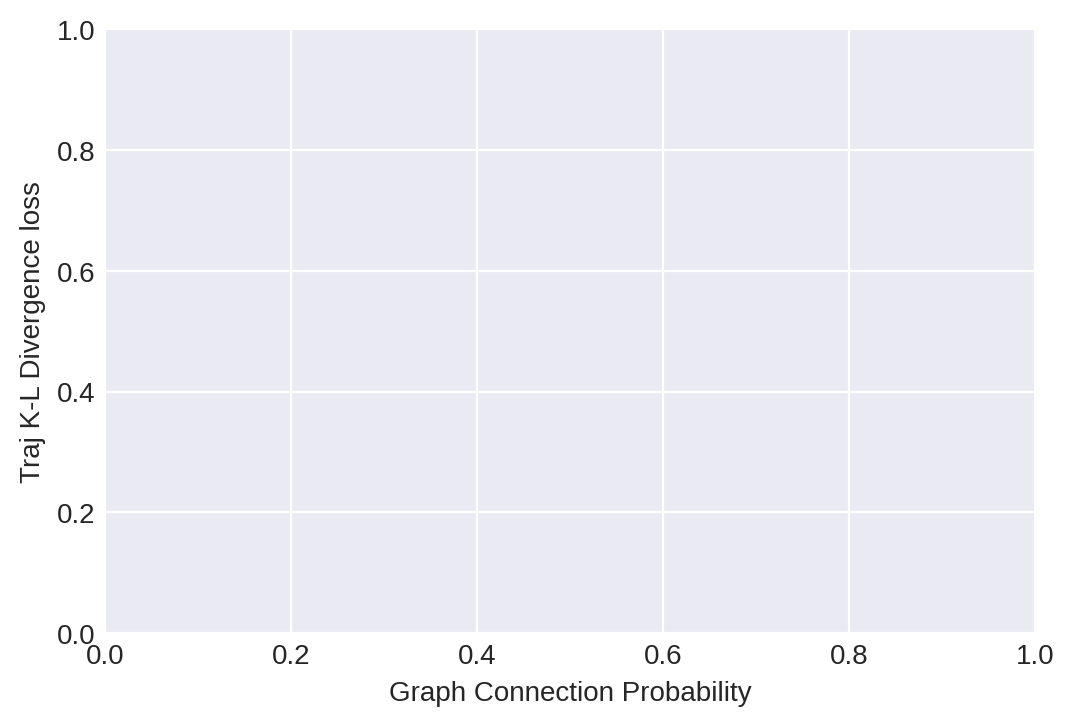

In [6]:
alpha = 0.5
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), dpi=200)
ax.set_xlabel('Graph Connection Probability')
ax.set_ylabel('Traj K-L Divergence loss')
# plt.scatter(p_values, np.array(box_T)[:,1], color='g', alpha=alpha)
ax.errorbar(p_values, box_T[:,1], yerr=(box_T[:,0], box_T[:,2]), fmt='o', color='C2', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4)
ax.errorbar(p_values, box_F[:,1], yerr=(box_F[:,0], box_F[:,2]), fmt='o', color='C0', alpha=alpha,
           elinewidth=0.5, capsize=2, markersize=4)
ax.set_yscale('log')

In [21]:
upper_quartile = np.percentile(quant_certainty_T, 75)

In [22]:
upper_quartile

0.8974647617629501

In [ ]:
marker_colors = []
predictions = dat[:,3].astype(bool)
certainties = dat[:,2]
cross_entropy = dat[:,1]
K_L = dat[:,0]
true_nodes = dat[:,4]
predicted_nodes = dat[:,5]
alpha = 0.5
# K_L, cross_entropy, certainties, predictions, true_nodes, predicted_nodes = np.array(dat, dtype=object)
for i in range(len(connecting_probability)):
    if predictions[i]:
        marker_colors.append('C2')
    else:
        marker_colors.append('C0')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), dpi=600)
ax[0,0].set_xlabel('Graph Connection Probability')
ax[0,0].set_ylabel('Traj K-L Divergence loss')
ax[0,0].set_yscale('log')
ax[0,1].set_xlabel('Graph Connection Probability')
ax[0,1].set_ylabel('Origin Inference Certainty')
fps = []
tps = []
fps_p_node = []
tps_p_node = []
for i, mc in enumerate(marker_colors):
    ax[0,0].plot(connecting_probability[i], K_L[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    ax[0,1].plot(connecting_probability[i], certainties[i], marker='.', markerfacecolor=mc,
               markeredgecolor='None', label=f'{bool(predictions[i])} Positive', alpha=alpha)
    if bool(predictions[i]):
        tps.append(certainties[i])
        tps_p_node.append(connecting_probability[i])
    else:
        fps.append(certainties[i])
        fps_p_node.append(connecting_probability[i])
bins = np.linspace(0, 1, 9)
counts_t, bins_t, bars_t = ax[1,0].hist(tps, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
counts_f, bins_f, bars_f = ax[1,0].hist(fps, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
fig.subplots_adjust(hspace=0.4, wspace=0.3)


bins_t = bins_t[1:]
accuracy = counts_t/(counts_f + counts_t)
# plt.figure(dpi=150)
ax[1,0].clear()
ax[1,0].plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
ax[1,0].plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
ax[1,0].set_xlabel('Origin Inference Certainty')
ax[1,0].set_ylabel('Accuracy')
legend = ax[1,0].legend()
bins_p_node = np.unique(connecting_probability)
counts_f_p_node, bins_f_p_node, bars_f_p_node = ax[1,1].hist(fps_p_node, bins, alpha=alpha, label='False Positive', color='C0', rwidth=1, edgecolor='k', linewidth=0.6)
counts_t_p_node, bins_t_p_node, bars_t_p_node = ax[1,1].hist(tps_p_node, bins, alpha=alpha, label='True Positive', color='C2', rwidth=1, edgecolor='k', linewidth=0.6)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0,0].legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.36, 1.42))
ax[1,1].clear()
accuracy_p_node = counts_t_p_node/(counts_f_p_node + counts_t_p_node)
non_nan_p_node = np.min(np.where(np.isfinite(accuracy_p_node)))
ax[1,1].plot(bins_t,accuracy_p_node, label='Maxent')
ax[1,1].set_xlabel('Graph Connection Probability')
ax[1,1].set_ylabel('Accuracy')
# plt.tight_layout()
# plt.savefig('adjust_p_grah.png', dpi=600)

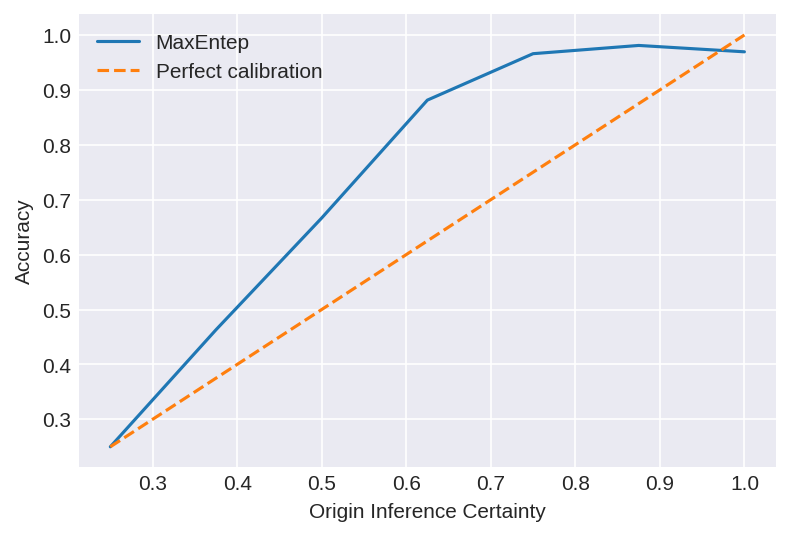

In [19]:
accuracy = counts_t/(counts_f + counts_t)
plt.figure(dpi=150)
plt.plot(bins_t, accuracy, label='py0')
non_nan = np.min(np.where(np.isfinite(accuracy)))
plt.plot([bins_t[non_nan],1],[bins_t[non_nan],1], '--', label='Perfect calibration')
plt.xlabel('Origin Inference Certainty')
plt.ylabel('Accuracy')
legend = plt.legend()

## Finding [Time Horizon](https://arxiv.org/abs/2006.11913)

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [7]:
def density_fxn(n, area=area, xi=0.005):
        return 2. - tf.math.exp(-xi * n / area)
sparsed_mobility_matrix = py0.sparse_graph_mobility(graph, dense_mobility_matrix)
sparsed_mobility_matrix_norm = sparsed_mobility_matrix / np.sum(sparsed_mobility_matrix, axis=1, keepdims=True)
# finding effective population
effective_population = np.array(population)[np.newaxis, :] @  sparsed_mobility_matrix_norm
ntot = np.sum(effective_population, axis=1)
# k is the avergae number of contacts across the whole population
k = 10.
f = density_fxn(effective_population)
# finding normalization factor
z = ntot * k / np.sum(effective_population * density_fxn(effective_population), axis=1)
print(f'z = {z}')
M =  np.array(population)*np.einsum('il,jl,l->ij', sparsed_mobility_matrix_norm, sparsed_mobility_matrix_norm, np.squeeze(f/effective_population))
def kth_term(matrix, k):
        # This function outputs the spectral radius of the input matrix (k-> inf)
        # using Gelfand's formula
        matrix = np.linalg.matrix_power(matrix, k)
        f_norm = np.linalg.norm(matrix, 'fro')
        a = f_norm**(1.0/k)
        return a
spectral_radius = kth_term(M,75)
print(f'spectral_radius = {spectral_radius}')
mu = 1/7
beta = 0.05
beta_prime = 0.025
epsilon = 0.6
R_0 = z * 1 / mu * (epsilon * beta + (1-epsilon) * beta_prime) * spectral_radius
print(f'R_0 = {R_0}')
t_max = np.log(ntot) / mu / (R_0-1)
print(f't_max = {t_max}')

z = [5.56176962]
spectral_radius = 1.9309664654011192
R_0 = [3.00708538]
t_max = [55.07528889]
